# Get Data Traffic Signs

In [ ]:
!gdown --id 1_JBwK6HKr66wcIccPrgaAxEthxS2G17S

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1_JBwK6HKr66wcIccPrgaAxEthxS2G17S
To: /content/train.zip
100% 53.9M/53.9M [00:00<00:00, 57.5MB/s]


In [ ]:
!unzip train.zip

Archive:  train.zip
  inflating: train/images/signal_3350_jpg.rf.7622bc2f88f6d51e027263c96e5b450d.jpg  
  inflating: train/images/signal_9210_jpg.rf.64ce2bc43c508e7eacde8757c1740973.jpg  
  inflating: train/labels/signal_11500_jpg.rf.85bb59bd63a3079064a80389428691f5.txt  
  inflating: train/labels/signal_2150_jpg.rf.ad01610bb7dff9191806b53865d5fcff.txt  
  inflating: train/labels/signal_2940_jpg.rf.963a23dc1b6945dd4b19de3e3fa0cdc9.txt  
  inflating: train/images/signal_11610_jpg.rf.2e7a02b2c182ef5a4945af9176d3b7a1.jpg  
  inflating: train/labels/signal_1650_jpg.rf.9cc6307366b8b22dff4cecaac4ea5f38.txt  
  inflating: train/images/signal_1860_jpg.rf.f3a0c8b1625470dee21d2628e3a48f2b.jpg  
  inflating: train/images/signal_11640_jpg.rf.d4cf29f401b78697adff326e0c017058.jpg  
  inflating: train/labels/signal_10760_jpg.rf.1aeded4910b8b5b6f741240f2ce9e152.txt  
  inflating: train/labels/signal_7500_jpg.rf.20de669573da55447954602c9dde94e9.txt  
  inflating: train/images/signal_11130_jpg.rf.306184

In [ ]:
with open('/content/train/labels/signal_12340_jpg.rf.e6c8ecc1bc3861aa7560d27e7d80502e.txt', 'r') as f:
  print(f.readlines())

['3 0.5984375 0.6515625 0.2328125 0.4015625\n', '0 0.23359375 0.48046875 0.121875 0.1921875']


In [ ]:
def convertBoundingBoxYOLO2COCO(img, fileTXT):
    file = open(fileTXT, 'r')
    data = file.readlines()
    file.close()
    image = cv2.imread(img)
    dh, dw, _ = image.shape
    coordinateConvert = []
    for dt in data:
        text, x, y, w, h = dt.split(' ')
        xmin = int((float(x) - float(w) / 2) * dw)
        xmax = int((float(x) + float(w) / 2) * dw)
        ymin = int((float(y) - float(h) / 2) * dh)
        ymax = int((float(y) + float(h) / 2) * dh)
        if xmin < 0:
            xmin = 0
        if xmax > dw - 1:
            xmax = dw - 1
        if ymin < 0:
            ymin = 0
        if ymax > dh - 1:
            ymax = dh - 1
        coordinateConvert.append([xmin, ymin, xmax, ymax])
    return coordinateConvert


class processingROI:
    def __init__(self, image, boundingBoxYOLO):
        self.boundingBoxYOLO = np.array(boundingBoxYOLO)
        self.image = image
        self.coordinateCenter = []

    def get_center_point(self):
        for i in range(len(self.boundingBoxYOLO)):
            x_center = (self.boundingBoxYOLO[i][0] + self.boundingBoxYOLO[i][2]) / 2
            y_center = (self.boundingBoxYOLO[i][1] + self.boundingBoxYOLO[i][3]) / 2
            self.coordinateCenter.append((x_center, y_center))
        return np.array(self.coordinateCenter)

    def order_points(self):
        rect = np.zeros((4, 2), dtype="float32")
        # self.suitable_cutting()
        s = self.get_center_point().sum(axis=1)
        rect[0] = self.get_center_point()[np.argmin(s)]
        rect[2] = self.get_center_point()[np.argmax(s)]
        diff = np.diff(self.get_center_point(), axis=1)
        rect[1] = self.get_center_point()[np.argmin(diff)]
        rect[3] = self.get_center_point()[np.argmax(diff)]
        return rect

    def _perspective_transform(self):
        (tl, tr, br, bl) = self.order_points()
        widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
        widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
        maxWidth = max(int(widthA), int(widthB))
        heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
        heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
        maxHeight = max(int(heightA), int(heightB))
        dst = np.array([
            [0, 0],
            [maxWidth - 1, 0],
            [maxWidth - 1, maxHeight - 1],
            [0, maxHeight - 1]], dtype="float32")
        M = cv2.getPerspectiveTransform(self.order_points(), dst)
        warped = cv2.warpPerspective(self.image, M, (maxWidth, maxHeight))
        return warped

    def suitable_cutting(self):
        for i in range(len(self.get_center_point())):
            if self.get_center_point()[i][0] < 2:
                self.get_center_point()[i][0] = 0
            elif (self.get_center_point()[i] > (self.image.shape[1] - 10, self.image.shape[0] - 10)).all():
                self.get_center_point()[i] = (self.image.shape[1], self.image.shape[0] - 10)
            elif self.get_center_point()[i][0] > self.image.shape[1] - 10 and self.get_center_point()[i][1] < 2:
                self.get_center_point()[i] = (self.image.shape[1], 0)
            elif self.get_center_point()[i][0] < 2 and self.get_center_point()[i][1] > self.image.shape[0] - 10:
                self.get_center_point()[i] = (0, self.image.shape[0])

    def __call__(self, *args, **kwargs):
        return self._perspective_transform()

In [ ]:
!rm -rf /content/train/results

In [ ]:
import cv2
import numpy as np
import os

folder_images = '/content/train/images'
folder_labels = '/content/train/labels'
folder_results = '/content/train/results'
if not os.path.exists(folder_results):
  os.makedirs(folder_results)
folder_left = folder_results + '/left'
folder_right = folder_results + '/right'
folder_stop = folder_results + '/stop'
folder_straight = folder_results + '/straight'

if not os.path.exists(folder_left):
  os.makedirs(folder_left)
if not os.path.exists(folder_right):
  os.makedirs(folder_right)
if not os.path.exists(folder_stop):
  os.makedirs(folder_stop)
if not os.path.exists(folder_straight):
  os.makedirs(folder_straight)
for file_image in os.listdir(folder_images):
    image = cv2.imread(os.path.join(folder_images, file_image))
    dh, dw, _ = image.shape
    image_name = os.path.splitext(file_image)[0]
    label = open(os.path.join(folder_labels, image_name + '.txt'), 'r')
    data = label.readlines()
    for i, dt in enumerate(data):
      text, x, y, w, h = dt.split(' ')
      xmin = int((float(x) - float(w) / 2) * dw)
      xmax = int((float(x) + float(w) / 2) * dw)
      ymin = int((float(y) - float(h) / 2) * dh)
      ymax = int((float(y) + float(h) / 2) * dh)
      if xmin < 0:
          xmin = 0
      if xmax > dw - 1:
          xmax = dw - 1
      if ymin < 0:
          ymin = 0
      if ymax > dh - 1:
          ymax = dh - 1
      cropped_image = image[ymin:ymax, xmin:xmax, :]
      if text == '0':
        cv2.imwrite(os.path.join(folder_left, image_name + "_" + str(i) + ".jpg"), cropped_image)
      elif text == '1':
        cv2.imwrite(os.path.join(folder_right, image_name + "_" + str(i) + ".jpg"), cropped_image)
      elif text == '2':
        cv2.imwrite(os.path.join(folder_stop, image_name + "_" + str(i) + ".jpg"), cropped_image)
      else:
        cv2.imwrite(os.path.join(folder_straight, image_name + "_" + str(i) + ".jpg"), cropped_image)

    # coordinates = convertBoundingBoxYOLO2COCO(os.path.join(folder_images, file_image), os.path.join(folder_labels, image_name + '.txt'))
    # processing = processingROI(image, coordinates)
    # cv2.imwrite(processing())

error: ignored

In [ ]:
# Create variable for pipline
PATH_foldername = "Lane_03" # Identify folder in ggdrive and change it the same "PATH_foldername"
PATH_folderrar = f"{PATH_foldername}.rar"
PATH_results = f"{PATH_foldername}_results"
PATH_nameClassJPG = "JPEGImages"
PATH_nameClassPNG = "SegmentationClassPNG"
# PATH of convert file
PATH_2segmentation = "/content/Segmentation"
PATH_folderClassPNG = f"{PATH_2segmentation}/{PATH_foldername}/{PATH_results}/{PATH_nameClassPNG}"
PATH_folderClassJPG = f"{PATH_2segmentation}/{PATH_foldername}/{PATH_results}/{PATH_nameClassJPG}"
PATH_train = f"/content/train"

src_labelme = "/content/labelme/examples/semantic_segmentation"

# PATH save a model train
PATH_weights = f"/content/drive/MyDrive/Dataset/Segmentation/{PATH_foldername}/weights"
PATH_csv = f"/content/a.csv"
#PATH of pretrained model
number_pretrained = "045" # Change to adjust pre-trained
PATH_foldrPre = "Lane_02/weights"
PATH_pretrained = f"/content/drive/MyDrive/Dataset/Segmentation/{PATH_foldrPre}/model-{number_pretrained}.h5"

# Train CNN

In [ ]:
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from PIL import Image
import os
from keras.utils import to_categorical
import random

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras.callbacks import CSVLogger
#Lấy tất cả đường đẫn đến ảnh
filenames=os.listdir("/content/train/results")
labels=[]
paths=[]
images=[]

for i in filenames:
    path=os.path.join("/content/train/results/{}".format(i))
    file_images=os.listdir(path)
    for j,f in enumerate(file_images):
        image=os.path.join(path,f)
        images.append(image)

#Xáo trộn đường dẫn
random.shuffle(images)

X = []

label = [p.split(os.path.sep)[-2] for p in images]
label = to_categorical(label, 4)
print(label)

for (j, imagePath) in enumerate(images):
    image = cv2.imread(imagePath)
    X.append(cv2.resize(image, (30,30)))
X = np.array(X)

X = X.astype('float32')/255 #đưa giá trị ảnh 0-255 về 0-1
X_train, X_valid, y_train, y_valid = train_test_split(X, label, test_size=0.2, random_state=0)


earlystop = EarlyStopping(patience=15)
learning_rate_reduction = ReduceLROnPlateau(monitor='accuracy',
                                            patience=4,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)
checkpoint = ModelCheckpoint("models/model-{epoch:03d}.h5",
                                 monitor='accuracy',
                                 verbose=1,
                                 save_best_only=False,
                                 mode='auto')

csv_logger = CSVLogger(PATH_csv, separator=',', append=False)

callbacks = [earlystop,learning_rate_reduction,checkpoint,csv_logger]


model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=(30, 30, 3)))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.5))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.5))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(4, activation='softmax'))

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(0.001),
    metrics=['accuracy']
)
model.summary()

!rm -rf "/content/models"

epochs = 50

history = model.fit(X, label, batch_size=32, epochs=epochs, validation_data=(X_valid, y_valid),callbacks=callbacks)
model.save('last.h5')

[[0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 ...
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 12, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooli

# Test model

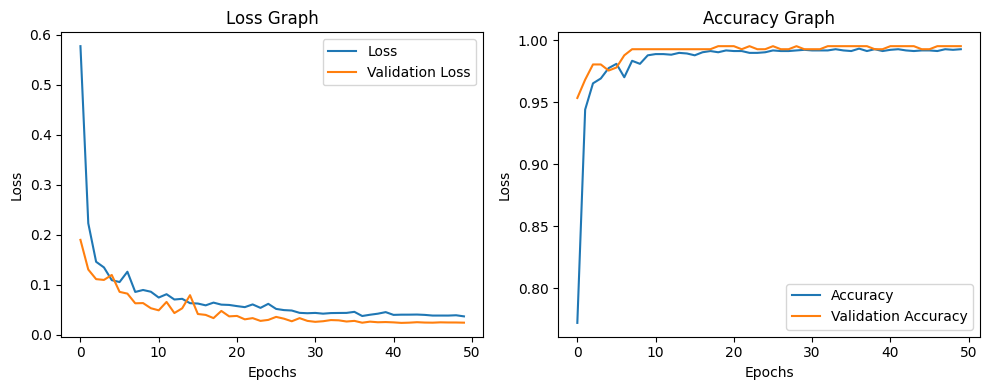

In [ ]:
import pandas as pd
DATA = pd.read_csv(PATH_csv)

epochs = DATA['epoch'].tolist()
train_loss = DATA['loss'].tolist()
val_loss = DATA['val_loss'].tolist()
train_acc = DATA['accuracy'].tolist()
val_acc = DATA['val_accuracy'].tolist()

fig, (axis1, axis2) = plt.subplots(1,2,figsize=(10,4))
# Loss graph
axis1.plot(epochs[0:100], train_loss[0:100], label='Loss')
axis1.plot(epochs[0:100], val_loss[0:100], label='Validation Loss')
axis1.set_title('Loss Graph')
axis1.set_xlabel('Epochs')
axis1.set_ylabel('Loss')
axis1.legend()
# Accuracy graph
axis2.plot(epochs[0:100], train_acc[0:100], label='Accuracy')
axis2.plot(epochs[0:100], val_acc[0:100], label='Validation Accuracy')
axis2.set_title('Accuracy Graph')
axis2.set_xlabel('Epochs')
axis2.set_ylabel('Loss')
axis2.legend()

plt.tight_layout()
plt.show()

In [ ]:
import os
# from keras.models import load_model
import tensorflow as tf

import cv2

import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from PIL import Image
import os
from keras.utils import to_categorical
import random


model2 = tf.keras.models.load_model('/content/models/model-050.h5')
correct = []
wrong = []
folder_test = '/content/train/results/3'
for file_test in os.listdir(folder_test):
  X_test = cv2.imread(os.path.join(folder_test, file_test))
  X_test=cv2.resize(X_test,(30, 30))
  X_test = X_test.astype('float32')/255

  X_test = X_test.reshape(1,30,30,3)
  predictions = model2.predict(X_test)
  if str(np.argmax(predictions[0])) == '3':
        correct.append(np.argmax(predictions[0]))
  else:
        wrong.append(np.argmax(predictions[0]))

print('Accuracy: {}'.format(len(correct) / len(os.listdir(folder_test))))

1/1 [==============================] - 0s 20ms/step
Accuracy: 0.9920948616600791


# Test 1 IMG

1/1 [==============================] - 0s 71ms/step
0.9892565
1/1 [==============================] - 0s 21ms/step
0.99947256
1/1 [==============================] - 0s 25ms/step
0.9998834


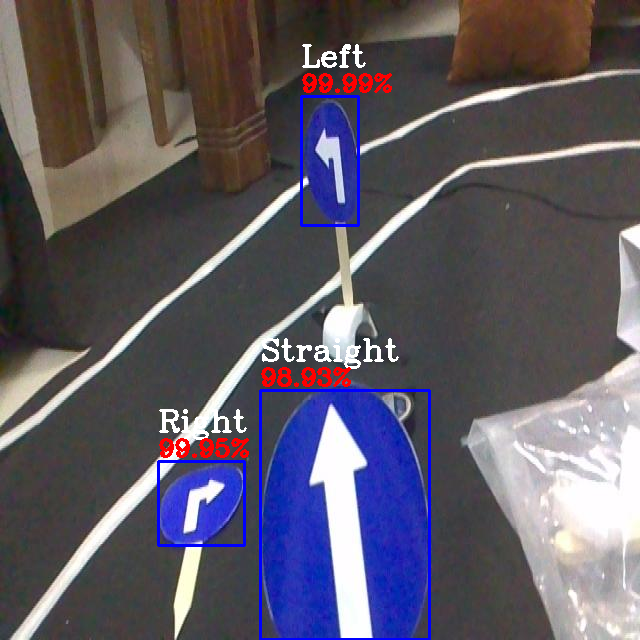

In [ ]:
import os
# from keras.models import load_model
import tensorflow as tf

import cv2

import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from PIL import Image
import os
from keras.utils import to_categorical
import random


model2 = tf.keras.models.load_model('models/model-050.h5')
name_class = ''
IMG = cv2.imread('/content/train/images/signal_12850_jpg.rf.5951c5782061c1946960673abeba41b3.jpg')

X_label = open("/content/train/labels/signal_12850_jpg.rf.5951c5782061c1946960673abeba41b3.txt","r").readlines()


# X_test = cv2.imread('/content/train/results/0/signal_10040_jpg.rf.bfd8535012620111253b3f4f04fb1644_1.jpg')
# w,h,d = X_test.shape
# X_test=cv2.resize(X_test,(30, 30))
# X_test = X_test.astype('float32')/255

# X_test = X_test.reshape(1,30,30,3)
# predictions = model2.predict(X_test)


for i, dt in enumerate(X_label):
  text, x, y, w, h = dt.split(' ')
  xmin = int((float(x) - float(w) / 2) * dw)
  xmax = int((float(x) + float(w) / 2) * dw)
  ymin = int((float(y) - float(h) / 2) * dh)
  ymax = int((float(y) + float(h) / 2) * dh)
  if xmin < 0:
      xmin = 0
  if xmax > dw - 1:
      xmax = dw - 1
  if ymin < 0:
      ymin = 0
  if ymax > dh - 1:
      ymax = dh - 1
  cv2.rectangle(IMG,(xmin,ymin),(xmax,ymax),(255,0,0),2)
  cropped_img = IMG[ymin:ymax, xmin:xmax,:]
  cropped_img=cv2.resize(cropped_img,(30, 30))
  cropped_img = cropped_img.astype('float32')/255
  cropped_img = cropped_img.reshape(1,30,30,3)
  predictions = model2.predict(cropped_img)

  if str(np.argmax(predictions[0])) == "0":
    name_class = "Left"
  if str(np.argmax(predictions[0])) == "1":
    name_class = "Right"
  if str(np.argmax(predictions[0])) == "2":
    name_class = "Stop"
  if str(np.argmax(predictions[0])) == "3":
    name_class = "Straight"

  IMG_accuracy = np.round(np.max(predictions[0])*100,2)
  IMG_accuracy = str(IMG_accuracy) +'%'
  # cv2.rectangle(IMG,())
  cv2.putText(IMG,name_class, (xmin,ymin-30),cv2.FONT_HERSHEY_COMPLEX, 1, (255, 255, 255), 2)
  cv2.putText(IMG,IMG_accuracy, (xmin,ymin-5),cv2.FONT_HERSHEY_COMPLEX, 0.8, (0, 0, 255), 2)
  print(np.max(predictions[0]))

Image.fromarray(cv2.cvtColor(IMG, cv2.COLOR_BGR2RGB))
